In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Load the Dataset:

In [ ]:
import zipfile

# Define dataset paths in Google Drive
dance_dataset_zip = '//content/drive/MyDrive/Dance Classification/Dance form dataset.zip'

# Extract datasets
with zipfile.ZipFile(dance_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/dance_dataset')

In [ ]:
# Paths
train_img_path = '/content/dance_dataset/dataset/train'
test_img_path = '/content/dance_dataset/dataset/test'
train_labels_file = '/content/dance_dataset/dataset/train.csv'

# Read Excel files
train_df = pd.read_csv(train_labels_file)

print(train_df.head())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi


#Dataset Preprocessing:

Rename Images with Labels

In [ ]:
import shutil

train_img_path = '/content/dance_dataset/dataset/train'
updated_img_path = '/content/dance_dataset/dataset/train_renamed'

# Create new folder
if os.path.exists(updated_img_path):
    shutil.rmtree(updated_img_path)
os.makedirs(updated_img_path)

# Read original CSV
train_df = pd.read_csv('/content/dance_dataset/dataset/train.csv')

# Keep track of label counters
label_counters = {}

for idx, row in train_df.iterrows():
    label = row['target']
    old_name = row['Image']

    if label not in label_counters:
        label_counters[label] = 0
    label_counters[label] += 1

    new_name = f"{label}_{label_counters[label]:03d}.jpg"

    src = os.path.join(train_img_path, old_name)
    dst = os.path.join(updated_img_path, new_name)

    shutil.copy(src, dst)

Organize Images into Label Folders

In [ ]:
from pathlib import Path

# Organize images into subfolders by label
organized_path = '/content/dance_dataset/dataset/train_organized'

if os.path.exists(organized_path):
    shutil.rmtree(organized_path)
os.makedirs(organized_path)

for file in os.listdir(updated_img_path):
    label = file.split('_')[0]  # Extract label from filename
    label_folder = os.path.join(organized_path, label)
    os.makedirs(label_folder, exist_ok=True)

    shutil.copy(os.path.join(updated_img_path, file), os.path.join(label_folder, file))

Display One Image from Each Dance Form

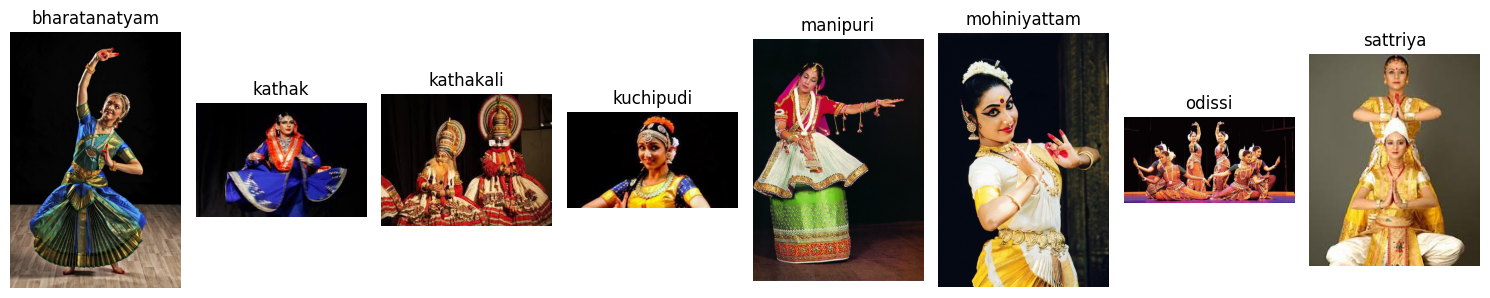

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the organized dataset
dance_dataset_path = '/content/dance_dataset/dataset/train_organized'

# Set up a 1-row plot with number of columns = number of classes
class_names = sorted(os.listdir(dance_dataset_path))
plt.figure(figsize=(15, 5))

for idx, dance_class in enumerate(class_names):
    class_path = os.path.join(dance_dataset_path, dance_class)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        continue

    sample_image_path = os.path.join(class_path, image_files[0])
    img = mpimg.imread(sample_image_path)

    # Plot the image
    plt.subplot(1, len(class_names), idx + 1)
    plt.imshow(img)
    plt.title(dance_class)
    plt.axis('off')

plt.tight_layout()
plt.show()

Augment Dance Dataset to 5x Size

[kathakali] Before: 47, Need to Add: 188
[kathakali] After: 235

[bharatanatyam] Before: 47, Need to Add: 188
[bharatanatyam] After: 235

[sattriya] Before: 45, Need to Add: 180
[sattriya] After: 225

[mohiniyattam] Before: 50, Need to Add: 200
[mohiniyattam] After: 250

[kathak] Before: 44, Need to Add: 176
[kathak] After: 220

[odissi] Before: 49, Need to Add: 196
[odissi] After: 245

[manipuri] Before: 36, Need to Add: 144
[manipuri] After: 180

[kuchipudi] Before: 46, Need to Add: 184
[kuchipudi] After: 230



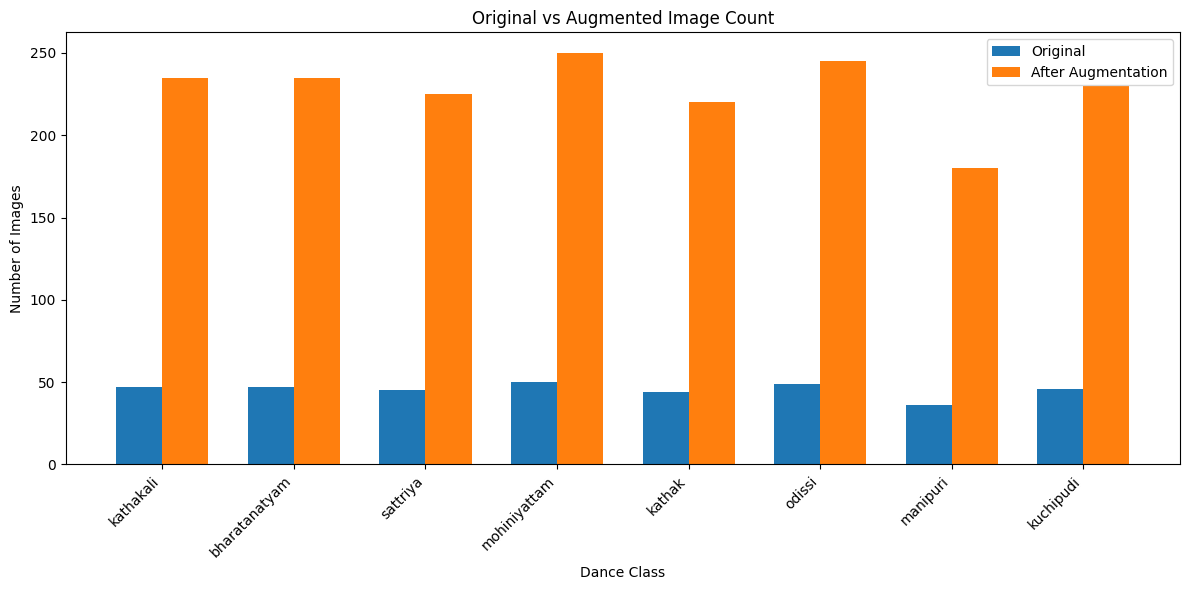

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Dataset path
dance_dataset_path = '/content/dance_dataset/dataset/train_organized'

# Image dimensions
img_height, img_width = 128, 128

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Store stats for plotting
class_names = []
original_counts = []
final_counts = []

# Function to augment and save images
def augment_and_save_images(folder_path, target_count):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    images_needed = target_count - current_count

    print(f"[{os.path.basename(folder_path)}] Before: {current_count}, Need to Add: {images_needed}")

    augmented = 0
    for img_file in image_files:
        if images_needed <= 0:
            break

        img_path = os.path.join(folder_path, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        aug_iter = datagen.flow(img_array, batch_size=1)

        for i in range(images_needed):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            aug_img = Image.fromarray(aug_img)
            aug_img.save(os.path.join(folder_path, f"aug_{augmented}_{img_file}"))
            augmented += 1
            images_needed -= 1
            if images_needed <= 0:
                break

    updated_count = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"[{os.path.basename(folder_path)}] After: {updated_count}\n")
    return current_count, updated_count

# Apply augmentation and collect stats
for dance_folder in os.listdir(dance_dataset_path):
    folder_path = os.path.join(dance_dataset_path, dance_folder)
    if os.path.isdir(folder_path):
        original, final = augment_and_save_images(folder_path, target_count=len(os.listdir(folder_path)) * 5)
        class_names.append(dance_folder)
        original_counts.append(original)
        final_counts.append(final)

# Plot bar chartx
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, original_counts, width, label='Original')
plt.bar(x + width/2, final_counts, width, label='After Augmentation')

plt.xlabel('Dance Class')
plt.ylabel('Number of Images')
plt.title('Original vs Augmented Image Count')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

#Split Dataset (Train & Validation)

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
train_dir = '/content/dance_dataset/dataset/train_organized'
img_height, img_width = 128, 128
batch_size = 32

# Get all image paths and labels
filepaths = []
labels = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_path, fname))
                labels.append(class_name)

# Create a DataFrame
df = pd.DataFrame({'filename': filepaths, 'class': labels})


from sklearn.model_selection import train_test_split
import pandas as pd


train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['class'], random_state=42)

# Print split sizes
print("Dance Classification Dataset:")
print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples:    {len(test_df)}")

Dance Classification Dataset:
Training samples:   1456
Validation samples: 182
Testing samples:    182


In [ ]:
'''import tensorflow as tf
from tensorflow.keras.applications import VGG19, InceptionV3, InceptionResNetV2, ConvNeXtTiny, Xception
from tensorflow.keras.layers import (Input, Layer, Conv2D, Multiply, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Reshape, Dense, Add, Activation,
                                     Concatenate, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# CBAM block
class CBAM(Layer):
    def __init__(self, filters=None, reduction=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction

    def build(self, input_shape):
        if self.filters is None:
            self.filters = input_shape[-1]
        self.shared_dense_one = Dense(self.filters // self.reduction, activation='relu')
        self.shared_dense_two = Dense(self.filters)
        self.conv_spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel attention
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)

        avg_pool = self.shared_dense_two(self.shared_dense_one(Reshape((1, 1, self.filters))(avg_pool)))
        max_pool = self.shared_dense_two(self.shared_dense_one(Reshape((1, 1, self.filters))(max_pool)))

        channel_attention = Activation('sigmoid')(Add()([avg_pool, max_pool]))
        x = Multiply()([inputs, channel_attention])

        # Spatial attention
        avg_pool = tf.reduce_mean(x, axis=3, keepdims=True)
        max_pool = tf.reduce_max(x, axis=3, keepdims=True)
        concat = Concatenate(axis=3)([avg_pool, max_pool])
        spatial_attention = self.conv_spatial(concat)

        return Multiply()([x, spatial_attention])

# Model builder with CBAM
def build_cbam_model(base_model_class, input_shape=(128, 128, 3), num_classes=8):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = CBAM()(x)  # Automatically gets filters from input
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize models with CBAM
input_shape = (128, 128, 3)
num_classes = 8

models = {
    'VGG19': build_cbam_model(VGG19, input_shape, num_classes),
    'InceptionV3': build_cbam_model(InceptionV3, input_shape, num_classes),
    'InceptionResNetV2': build_cbam_model(InceptionResNetV2, input_shape, num_classes),
    'ConvNeXtTiny': build_cbam_model(ConvNeXtTiny, input_shape, num_classes),
    'Xception': build_cbam_model(Xception, input_shape, num_classes)
}

# Print model summaries
for name, model in models.items():
    print(f"\n{'='*40}\n{name} with CBAM Summary\n{'='*40}")
    model.summary()'''

'import tensorflow as tf\nfrom tensorflow.keras.applications import VGG19, InceptionV3, InceptionResNetV2, ConvNeXtTiny, Xception\nfrom tensorflow.keras.layers import (Input, Layer, Conv2D, Multiply, GlobalAveragePooling2D,\n                                     GlobalMaxPooling2D, Reshape, Dense, Add, Activation,\n                                     Concatenate, Dropout)\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\n\n# CBAM block\nclass CBAM(Layer):\n    def __init__(self, filters=None, reduction=16, **kwargs):\n        super(CBAM, self).__init__(**kwargs)\n        self.filters = filters\n        self.reduction = reduction\n\n    def build(self, input_shape):\n        if self.filters is None:\n            self.filters = input_shape[-1]\n        self.shared_dense_one = Dense(self.filters // self.reduction, activation=\'relu\')\n        self.shared_dense_two = Dense(self.filters)\n        self.conv_spatial = Conv2D(1, kernel_size=7, padding=\

In [ ]:
'''from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Dictionary to store histories
histories = {}

for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name} with CBAM...\n{'='*50}")

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=15,
        callbacks=[early_stopping],
        verbose=1
    )
    histories[name] = history'''

'from tensorflow.keras.callbacks import EarlyStopping\nimport matplotlib.pyplot as plt\n\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=3, restore_best_weights=True)\n\n# Dictionary to store histories\nhistories = {}\n\nfor name, model in models.items():\n    print(f"\n{\'=\'*50}\nTraining {name} with CBAM...\n{\'=\'*50}")\n\n    history = model.fit(\n        train_generator,\n        validation_data=val_generator,\n        epochs=15,\n        callbacks=[early_stopping],\n        verbose=1\n    )\n    histories[name] = history'

In [ ]:
'''# Plotting function
def plot_history(histories):
    for name, history in histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        plt.figure(figsize=(14, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.title(f'{name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Call the plotting function
plot_history(histories)'''

"# Plotting function\ndef plot_history(histories):\n    for name, history in histories.items():\n        acc = history.history['accuracy']\n        val_acc = history.history['val_accuracy']\n        loss = history.history['loss']\n        val_loss = history.history['val_loss']\n        epochs_range = range(1, len(acc) + 1)\n\n        plt.figure(figsize=(14, 5))\n\n        # Accuracy plot\n        plt.subplot(1, 2, 1)\n        plt.plot(epochs_range, acc, label='Training Accuracy')\n        plt.plot(epochs_range, val_acc, label='Validation Accuracy')\n        plt.title(f'{name} - Accuracy')\n        plt.xlabel('Epochs')\n        plt.ylabel('Accuracy')\n        plt.legend()\n\n        # Loss plot\n        plt.subplot(1, 2, 2)\n        plt.plot(epochs_range, loss, label='Training Loss')\n        plt.plot(epochs_range, val_loss, label='Validation Loss')\n        plt.title(f'{name} - Loss')\n        plt.xlabel('Epochs')\n        plt.ylabel('Loss')\n        plt.legend()\n\n        plt.tight_l

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, InceptionV3, InceptionResNetV2, ConvNeXtTiny, Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


def build_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Parameters
input_shape = (128, 128, 3)
num_classes = 8

# Build models with improved regularization
models2 = {
    'VGG19': build_model(VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')),
    'InceptionV3': build_model(InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet')),
    'InceptionResNetV2': build_model(InceptionResNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')),
    'ConvNeXtTiny': build_model(ConvNeXtTiny(input_shape=(128, 128, 3), include_top=False, weights='imagenet')),
    'Xception': build_model(Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))
}

# Print model summaries
for name, model in models2.items():
    print(f"\n{'='*40}\n{name} summary\n{'='*40}")
    model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

VGG19 summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,074,120 (80.39 MB)

 Trainable params: 1,049,736 (4.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)


InceptionV3 summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,852,520 (87.18 MB)

 Trainable params: 1,049,736 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


InceptionResNetV2 summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 2, 2, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,124,328 (210.28 MB)

 Trainable params: 787,592 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)


ConvNeXtTiny summary


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 4, 4, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,394,152 (112.13 MB)

 Trainable params: 1,574,024 (6.00 MB)

 Non-trainable params: 27,820,128 (106.13 MB)


Xception summary


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,056,944 (95.58 MB)

 Trainable params: 4,195,464 (16.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Define image properties and batch size
img_height, img_width = 128, 128
batch_size = 32

# Set up the data generator
datagen = ImageDataGenerator(rescale=1./255)

# Train generator using train_df
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator using val_df
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Dictionary to store histories
histories2 = {}

# Train each model using the train/val generators
for name, model in models2.items():
    print(f"\n{'='*50}\nTraining {name} ...\n{'='*50}")

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        verbose=1
    )
    histories2[name] = history

Found 1456 validated image filenames belonging to 8 classes.
Found 182 validated image filenames belonging to 8 classes.

Training VGG19 ...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.5608 - loss: 1.4914 - val_accuracy: 0.8516 - val_loss: 0.3776
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8891 - loss: 0.3785 - val_accuracy: 0.8901 - val_loss: 0.3278
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9166 - loss: 0.2609 - val_accuracy: 0.8901 - val_loss: 0.3124
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9302 - loss: 0.2157 - val_accuracy: 0.8956 - val_loss: 0.3244
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9415 - loss: 0.1692 - val_accuracy: 0.9121 - val_loss: 0.3168
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9498 - loss: 0.1501 - val_accuracy: 0.9011 - val_loss: 0.3058
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9612 - loss: 0.1216 - val_accuracy: 0.9286 - val_loss: 0.2469
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9673 - loss: 0.0939 - val_accuracy: 0.9066 - val_loss: 

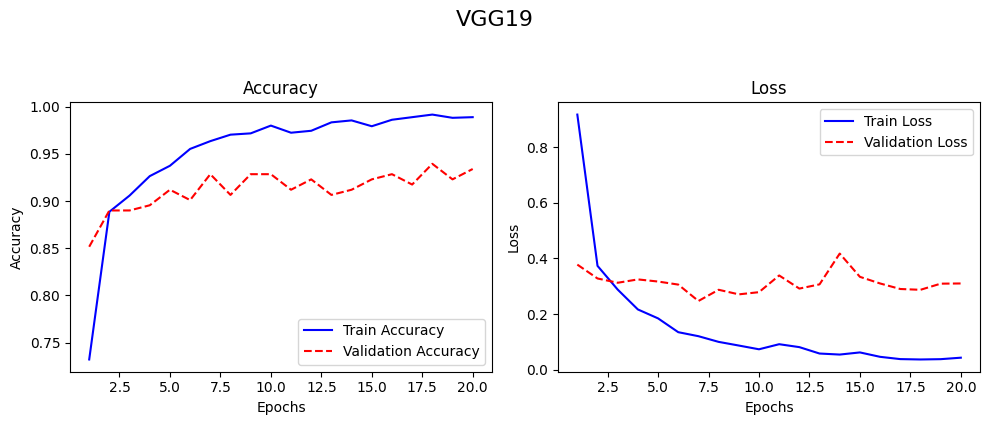

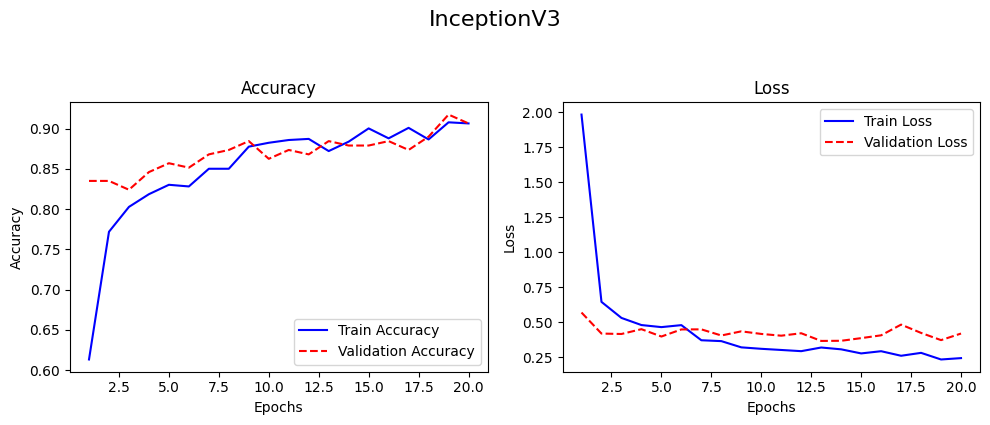

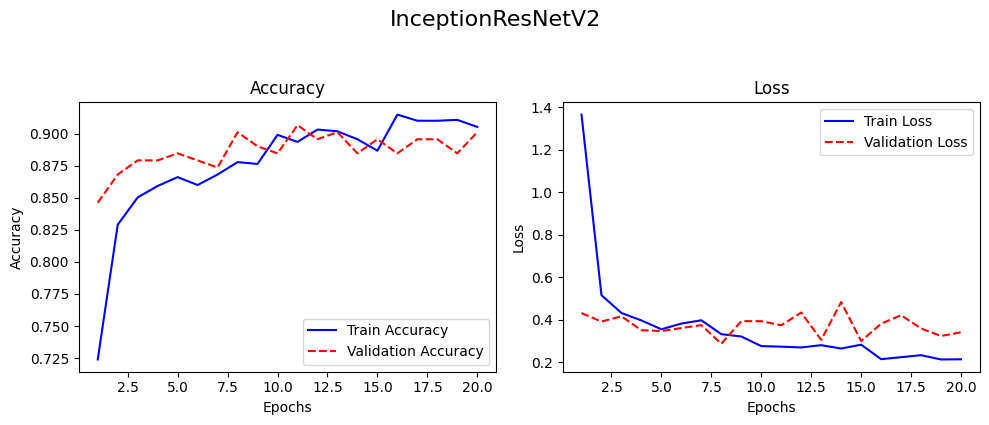

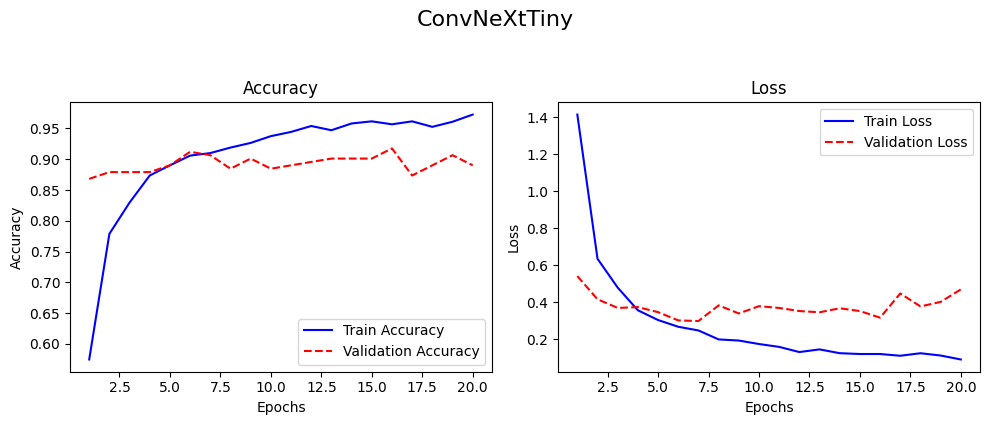

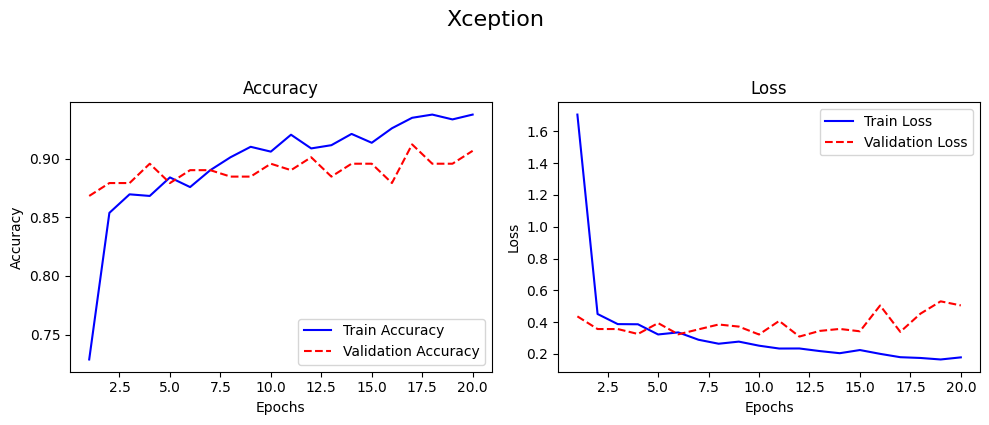

In [ ]:
import matplotlib.pyplot as plt

# Plotting function for accuracy and loss
def plot_history(histories):
    for name, history in histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))  # Adjusted size for better side-by-side layout

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, 'b-', label='Train Accuracy')
        plt.plot(epochs_range, val_acc, 'r--', label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, 'b-', label='Train Loss')
        plt.plot(epochs_range, val_loss, 'r--', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        # Model name at top center
        plt.suptitle(name, fontsize=16, y=1.05)

        plt.tight_layout()
        plt.show()

# Example usage
plot_history(histories2)

In [ ]:
results = []

for name, history in histories2.items():
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    results.append({
        'Model': name,
        'Train Accuracy': round(train_acc, 4),
        'Validation Accuracy': round(val_acc, 4),
        'Train Loss': round(train_loss, 4),
        'Validation Loss': round(val_loss, 4)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,VGG19,0.9890,0.9341,0.0432,0.3098
1,InceptionV3,0.9066,0.9066,0.2441,0.4198
2,InceptionResNetV2,0.9052,0.9011,0.2146,0.3415
3,ConvNeXtTiny,0.9725,0.8901,0.0913,0.4699
4,Xception,0.9375,0.9066,0.1780,0.5048


In [ ]:
import warnings
warnings.filterwarnings('ignore')


# Define your project directory in Drive
project_path = '/content/drive/MyDrive/Dance Classification/Saved models'

# Create the directory if it doesn't exist
import os
os.makedirs(project_path, exist_ok=True)

# Save all models as .h5 files to your project folder in Drive
for name, model in models2.items():
    model.save(os.path.join(project_path, f"{name}.h5"))
    print(f"{name} saved to Drive at: {os.path.join(project_path, f'{name}.h5')}")

VGG19 saved to Drive at: /content/drive/MyDrive/Dance Classification/Saved models/VGG19.h5


InceptionV3 saved to Drive at: /content/drive/MyDrive/Dance Classification/Saved models/InceptionV3.h5


InceptionResNetV2 saved to Drive at: /content/drive/MyDrive/Dance Classification/Saved models/InceptionResNetV2.h5


ConvNeXtTiny saved to Drive at: /content/drive/MyDrive/Dance Classification/Saved models/ConvNeXtTiny.h5
Xception saved to Drive at: /content/drive/MyDrive/Dance Classification/Saved models/Xception.h5


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 182 validated image filenames belonging to 8 classes.


In [ ]:
from sklearn.metrics import classification_report

y_true = test_generator.classes
target_names = list(test_generator.class_indices.keys())

for name, model in models2.items():
    print(f"\n{name} Evaluation on Test Data")

    # Predict class probabilities
    y_pred_probs = model.predict(test_generator)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)


VGG19 Evaluation on Test Data


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
               precision    recall  f1-score   support

bharatanatyam       0.86      0.83      0.84        23
       kathak       0.91      0.95      0.93        22
    kathakali       1.00      1.00      1.00        23
    kuchipudi       0.87      0.87      0.87        23
     manipuri       1.00      1.00      1.00        18
 mohiniyattam       0.92      0.92      0.92        25
       odissi       0.92      0.92      0.92        25
     sattriya       0.96      0.96      0.96        23

     accuracy                           0.93       182
    macro avg       0.93      0.93      0.93       182
 weighted avg       0.93      0.93      0.93       182


InceptionV3 Evaluation on Test Data
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
               precision    recall  f1-score   support

bharatanatyam       0.90      0.78      0.84        23
       kathak       1.00      0.82      0.90        22
    kathakali       0.96      1.00      0.98        23
   

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
               precision    recall  f1-score   support

bharatanatyam       0.79      0.83      0.81        23
       kathak       1.00      0.82      0.90        22
    kathakali       0.96      1.00      0.98        23
    kuchipudi       0.80      0.87      0.83        23
     manipuri       0.89      0.94      0.92        18
 mohiniyattam       0.85      0.92      0.88        25
       odissi       0.84      0.84      0.84        25
     sattriya       0.95      0.83      0.88        23

     accuracy                           0.88       182
    macro avg       0.89      0.88      0.88       182
 weighted avg       0.88      0.88      0.88       182


ConvNeXtTiny Evaluation on Test Data


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step
               precision    recall  f1-score   support

bharatanatyam       0.73      0.83      0.78        23
       kathak       0.95      0.82      0.88        22
    kathakali       0.88      1.00      0.94        23
    kuchipudi       1.00      0.91      0.95        23
     manipuri       0.86      1.00      0.92        18
 mohiniyattam       0.92      0.96      0.94        25
       odissi       0.96      0.88      0.92        25
     sattriya       1.00      0.87      0.93        23

     accuracy                           0.91       182
    macro avg       0.91      0.91      0.91       182
 weighted avg       0.91      0.91      0.91       182


Xception Evaluation on Test Data
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step
               precision    recall  f1-score   support

bharatanatyam       0.76      0.83      0.79        23
       kathak       0.83      0.91      0.87        22
    kathakali       0.92      1.00      0.96        23
    

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# 1. Predict softmax probabilities from all models using test_generator
predictions = []

for name, model in models2.items():
    print(f"Predicting with {name}...")
    preds = model.predict(test_generator, verbose=0)
    predictions.append(preds)  # shape: (num_samples, num_classes)

# 2. Average the predictions
avg_probs = np.mean(predictions, axis=0)  # shape: (num_samples, num_classes)

# 3. Get predicted classes
ensemble_preds = np.argmax(avg_probs, axis=1)

# 4. Get true labels (already one-hot encoded by the generator)
true_labels = test_generator.labels

# 5. Compute accuracy
ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)
print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")

# 6. Classification Report
target_names = list(test_generator.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(true_labels, ensemble_preds, target_names=target_names))

Predicting with VGG19...
Predicting with InceptionV3...
Predicting with InceptionResNetV2...
Predicting with ConvNeXtTiny...
Predicting with Xception...

Ensemble Accuracy: 0.9176

Classification Report:

               precision    recall  f1-score   support

bharatanatyam       0.79      0.83      0.81        23
       kathak       0.91      0.91      0.91        22
    kathakali       0.96      1.00      0.98        23
    kuchipudi       0.91      0.87      0.89        23
     manipuri       1.00      1.00      1.00        18
 mohiniyattam       0.92      0.92      0.92        25
       odissi       0.88      0.92      0.90        25
     sattriya       1.00      0.91      0.95        23

     accuracy                           0.92       182
    macro avg       0.92      0.92      0.92       182
 weighted avg       0.92      0.92      0.92       182



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Define weights for each model (must sum to 1 or will be normalized)
weights = {
    'VGG19': 0.25,
    'InceptionV3': 0.15,
    'InceptionResNetV2': 0.15,
    'ConvNeXtTiny': 0.25,
    'Xception': 0.20
}

# Normalize weights just in case they don’t sum to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# 1. Predict softmax probabilities from all models
weighted_preds = None
for name, model in models2.items():
    print(f"Predicting with {name}...")
    preds = model.predict(test_generator, verbose=0)  # shape: (num_samples, num_classes)
    weight = weights.get(name, 0)

    if weighted_preds is None:
        weighted_preds = weight * preds
    else:
        weighted_preds += weight * preds

# 2. Get predicted classes
ensemble_preds = np.argmax(weighted_preds, axis=1)

# 3. Get true labels (already integer format from generator)
true_labels = test_generator.labels

# 4. Compute accuracy
ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)
print(f"\nWeighted Ensemble Accuracy: {ensemble_accuracy:.4f}")

# 5. Classification Report
target_names = list(test_generator.class_indices.keys())
print("\nWeighted Ensemble Classification Report:\n")
print(classification_report(true_labels, ensemble_preds, target_names=target_names))

Predicting with VGG19...
Predicting with InceptionV3...
Predicting with InceptionResNetV2...
Predicting with ConvNeXtTiny...
Predicting with Xception...

Weighted Ensemble Accuracy: 0.9231

Weighted Ensemble Classification Report:

               precision    recall  f1-score   support

bharatanatyam       0.83      0.83      0.83        23
       kathak       0.91      0.91      0.91        22
    kathakali       0.96      1.00      0.98        23
    kuchipudi       0.91      0.91      0.91        23
     manipuri       1.00      1.00      1.00        18
 mohiniyattam       0.92      0.92      0.92        25
       odissi       0.88      0.92      0.90        25
     sattriya       1.00      0.91      0.95        23

     accuracy                           0.92       182
    macro avg       0.93      0.93      0.93       182
 weighted avg       0.92      0.92      0.92       182

